In [1]:
from matplotlib import pyplot as plt
import numpy as np
import numba

In [8]:
MAX_ITER = 256
CENTER = -0.8+0.0j
EXTENT = 3.0 + 3.0j

WIDTH = 1024
HEIGHT = 1024

SCALE = max((EXTENT / WIDTH).real, (EXTENT/HEIGHT).imag)

In [9]:
def compute_mandelbrot(height=HEIGHT, width=WIDTH, scale=SCALE, max_iter=MAX_ITER, center=CENTER, extent=EXTENT):
    result = np.zeros((height, width), int)
    for j in range(height):
        for i in range(width):
            c = center + (i - width // 2 + (j - height //2) * 1j) * scale
            z = 0

            for k in range(max_iter):
                z = z**2 + c

                if (z * z.conjugate()).real > 4.0:
                    break

                result[j, i] = k
    return result

In [72]:
%timeit compute_mandelbrot()

1.4 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
@numba.jit(nopython=True, nogil=True)
def compute_mandelbrot_numba(height=HEIGHT, width=WIDTH, scale=SCALE, max_iter=MAX_ITER, center=CENTER, extent=EXTENT):
    result = np.zeros((height, width), np.int64)
    for j in range(height):
        for i in range(width):
            c = center + (i - width // 2 + (j - height //2) * 1j) * scale
            z = 0

            for k in range(max_iter):
                z = z**2 + c

                if (z * z.conjugate()).real > 4.0:
                    break

                result[j, i] = k

In [11]:
%timeit compute_mandelbrot_numba()

186 ms ± 4.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
@numba.jit(nopython=True, parallel=True, nogil=True)
def compute_mandelbrot_numba_parallel(height=HEIGHT, width=WIDTH, scale=SCALE, max_iter=MAX_ITER, center=CENTER, extent=EXTENT):
    result = np.zeros((height, width), np.int64)
    for j in range(height):
        for i in range(width):
            c = center + (i - width // 2 + (j - height //2) * 1j) * scale
            z = 0

            for k in range(max_iter):
                z = z**2 + c

                if (z * z.conjugate()).real > 4.0:
                    break

                result[j, i] = k


In [13]:
%timeit compute_mandelbrot_numba_parallel()

172 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
import dask.bag as db

@numba.jit(nopython=True, nogil=True)
def iterate_mandelbrot(coords, width, height, scale, max_iter, center, extent):    
    i, j = coords
    z = 0
    c = center + (i - width // 2 + (j - height //2) * 1j) * scale
    
    for k in range(max_iter):
        z = z**2 + c

        if (z * z.conjugate()).real > 4.0:
            break
    return k

def compute_mandelbrot_dask(width=WIDTH, height=HEIGHT, scale=SCALE, max_iter=MAX_ITER, center=CENTER, extent=EXTENT):
    initial_state = zip(range(width), range(height))
    bag = db.from_sequence(initial_state)
    
    
    
    return bag.map(lambda x: iterate_mandelbrot(x, width, height, scale, max_iter, center, extent))
    

In [23]:
%timeit compute_mandelbrot_dask().compute(scheduler='threads')

19.6 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
result = compute_mandelbrot()

Text(0, 0.5, '$\\Im(c)$')

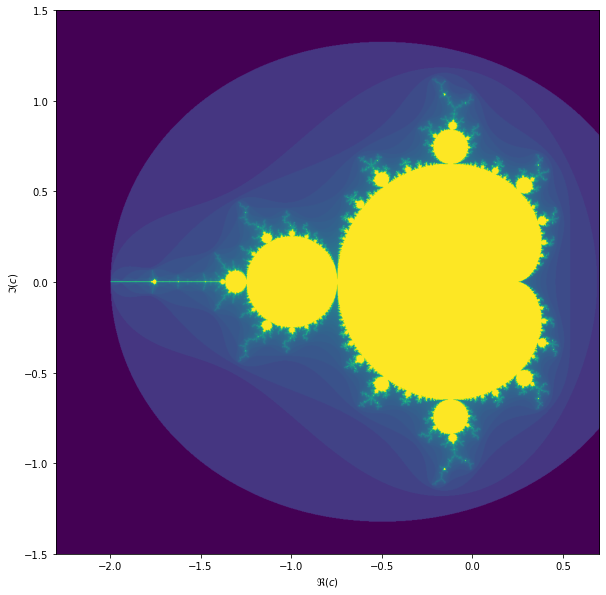

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_extent = (WIDTH + 1j * HEIGHT) * SCALE

z1 = center - plot_extent / 2
z2 = z1 + plot_extent

ax.imshow(result**(1/3), origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag))
ax.set_xlabel("$\Re(c)$")
ax.set_ylabel("$\Im(c)$")